# What's in a box score?

This study spurred out of looking at a box score for a particular game with many hits but few runs. It got me thinking "what should my expectation on number of runs be based on the hits?" Of course the two are related but there's a _lot_ of other information that goes into the number of runs, so I wanted to investigate how well I could predict the score based on this limited information.

The original analysis is shown first for posterity (performed mid-2019), however I later decided to come back and change the approach after rethinking this project.

In [1]:
from pybaseball import retrosheet
import pandas as pd
pd.options.display.max_columns=999
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.edgecolor"]= "white"
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.metrics import mean_squared_error,r2_score
import pymc3 as pm
import arviz as az
SHADE_COLOR="#5626C4"
SHADE_ALPHA=0.15
SEED=4693 # happy birthday to me

## Get data - Retrosheet

In [2]:
logs = retrosheet.season_game_logs(2018)

In [3]:
hits = logs["visiting_hits"].append(logs["home_hits"])
runs = logs["visiting_score"].append(logs["home_score"])

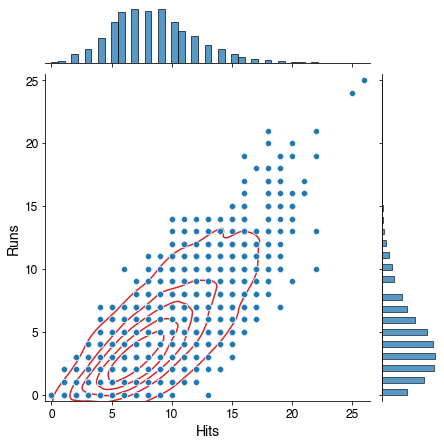

In [4]:
axes = sns.jointplot(x=hits, y=runs, kind="scatter",xlim=(-0.5,max(hits+0.5)), ylim=(-0.5,max(runs+0.5)))
axes.plot_joint(sns.kdeplot, color="tab:red", zorder=0, levels=6)
plt.sca(axes.ax_joint)
plt.xlabel("Hits", fontsize=14)
plt.ylabel("Runs", fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig("../plots/runs_v_hits/raw_data", facecolor="white", bbox_inches="tight")

----

### Updated Analysis (Nov 2020)

A better formulated answer to this question is to approach it from a Bayesian mindset. What I was originally asking was "conditional on the number of hits, what's the likely number of runs?" We can do this using Bayesian linear regression, and get proper uncertainty estimates, which is very relevant to this question.

Start by building a simple linear model. 

Priors:

- I assume that the y-intercept will be less than 0, since it's very rare to runs without hits (just on many BB/HBP events), but you very often get hits without runs.
- The slope ought to be positive but less than 1.
- The error term I'll set very wide, using a half-normal distribution

In [5]:
bayes_lr = pm.Model()

with bayes_lr:

    # Priors
    α = pm.Normal("α", mu=-0.5, sd=1)
    β = pm.Normal("β", mu=0.5, sd=0.75)
    ϵ = pm.HalfNormal("ϵ", sigma=2.5)
    
    # Linear Regression
    μ = pm.Deterministic("μ", α + β * hits)
    # Outcome
    outcome = pm.Normal("Runs", mu=μ, sd=ϵ, observed=runs)
    
    
    # Sample from model
    trace = pm.sample(3000, tune=2000, chains=2, cores=2, return_inferencedata=True, random_seed=SEED)    
    prior = pm.sample_prior_predictive(200)
    trace.extend(az.from_pymc3(prior=prior))
    ppc = pm.sample_posterior_predictive(trace, samples=6000)
    trace.extend(az.from_pymc3(posterior_predictive=ppc))
        
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 32 seconds.


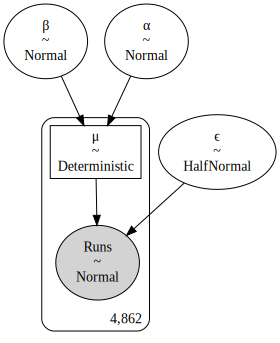

In [6]:
pm.model_to_graphviz(bayes_lr)

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

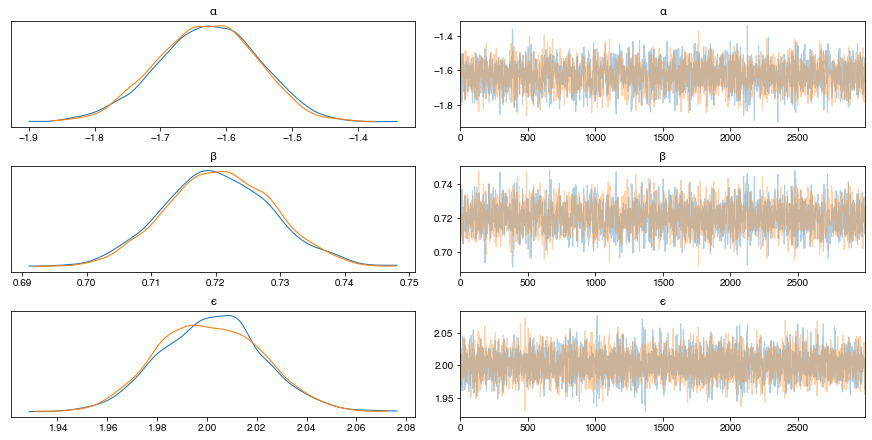

In [7]:
az.plot_trace(trace, var_names=["α", "β", "ϵ"])

The model seems to fit well, so let's look at how it looks on the output data

/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


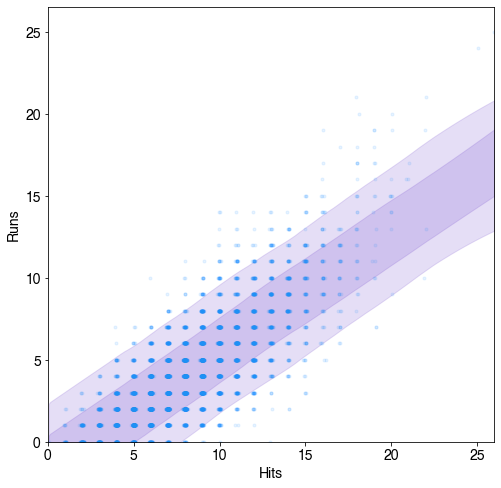

In [8]:
fig = plt.figure(figsize=(8,8))
ax =plt.gca()
az.plot_hdi(hits, ppc["Runs"], hdi_prob=0.68, color=SHADE_COLOR, ax=ax, fill_kwargs={"alpha":SHADE_ALPHA})
az.plot_hdi(hits, ppc["Runs"], hdi_prob=0.95, color=SHADE_COLOR, ax=ax, fill_kwargs={"alpha":SHADE_ALPHA})
# add jitter
x = np.random.normal(hits, 0.05, size=len(hits))
plt.plot(x, runs, '.',color="dodgerblue", alpha=0.1)
plt.ylim(bottom=0)
plt.xlim(left=0,right=26)
plt.tick_params(labelsize=14)
plt.xlabel("Hits", fontsize=14)
plt.ylabel("Runs",fontsize=14);

This is nice, but there's some issues. The uncertainty doesn't cover the outliers, and the residual space appears is systematically biased.

## Consider a model more robust to outliers

Outcome modeled by T-distribution rather than normal in order to make it more robust against outlier events, hopefully widen the 95% CI too.

In [9]:
robust_bayes_lr = pm.Model()

with robust_bayes_lr:

    # Priors
    α = pm.Normal("α", mu=-0.5, sd=1)
    β = pm.Normal("β", mu=0.5, sd=0.75)
    ϵ = pm.HalfNormal("ϵ", sigma=2.5)
    ν_ = pm.Exponential("ν_", 1/30)
    ν = pm.Deterministic("ν", ν_ + 1)
    
    # Linear Regression
    μ = pm.Deterministic("μ", α + β * hits)
    # Outcome
    outcome = pm.StudentT("Runs", mu=μ, sd=ϵ, nu=ν, observed=runs)
    
    
    # Sample from model
    trace_robust = pm.sample(3000, tune=1500, chains=2, cores=2, return_inferencedata=True, random_seed=SEED)    
    prior_robust = pm.sample_prior_predictive(200)
    trace_robust.extend(az.from_pymc3(prior=prior_robust))
    ppc_robust = pm.sample_posterior_predictive(trace_robust, samples=6000)
    trace_robust.extend(az.from_pymc3(posterior_predictive=ppc_robust))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_, ϵ, β, α]


Sampling 2 chains for 1_500 tune and 3_000 draw iterations (3_000 + 6_000 draws total) took 41 seconds.
The acceptance probability does not match the target. It is 0.8857634610470678, but should be close to 0.8. Try to increase the number of tuning steps.


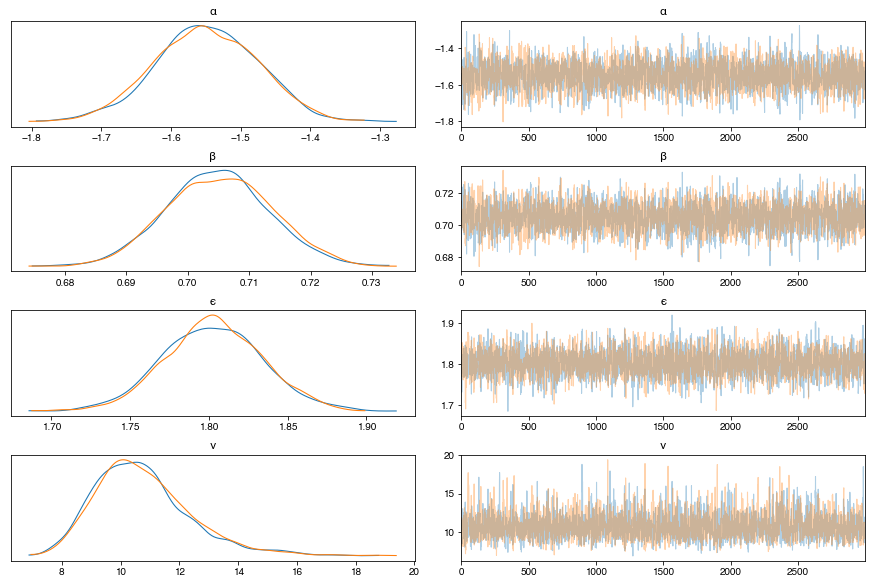

In [10]:
az.plot_trace(trace_robust, var_names=["α", "β", "ϵ","ν"]);

#### Model comparison

In [11]:
comp_WAIC = pm.compare({"normal": trace, "studentT": trace_robust})
comp_WAIC

/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
studentT,0,-10237.3,4.39582,0,1,56.8008,0,False,log
normal,1,-10274.1,3.96945,36.7548,2.21368e-08,55.2717,10.3218,False,log


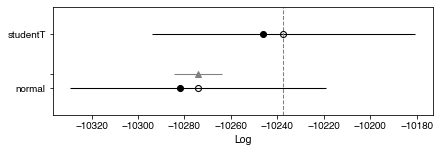

In [12]:
pm.compareplot(comp_WAIC);

StudentT Model appears to be slightly better, but within uncertainty bands so can't say for certain

/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


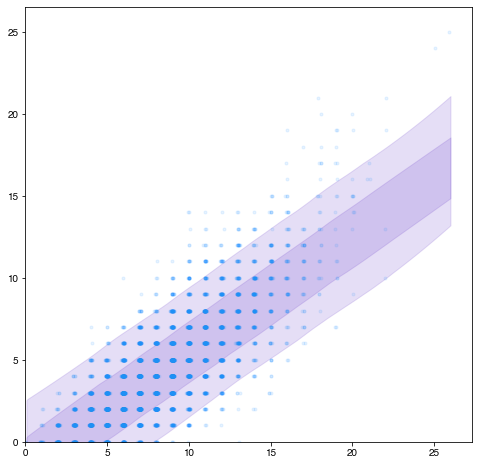

In [13]:
fig = plt.figure(figsize=(8,8))
ax =plt.gca()
az.plot_hdi(hits, ppc_robust["Runs"], hdi_prob=0.68, color=SHADE_COLOR, ax=ax, fill_kwargs={"alpha":SHADE_ALPHA})
az.plot_hdi(hits, ppc_robust["Runs"], hdi_prob=0.95, color=SHADE_COLOR, ax=ax, fill_kwargs={"alpha":SHADE_ALPHA})
# add jitter
x = np.random.normal(hits, 0.05, size=len(hits))
plt.scatter(x, runs, marker=".", color='dodgerblue', alpha=0.1)
plt.ylim(bottom=0)
plt.xlim(left=0);

Looks... about the same. What if we try to include the non-constant variance (heteroscedasticity) in the model?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_b, σ_m, β, α]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 51 seconds.


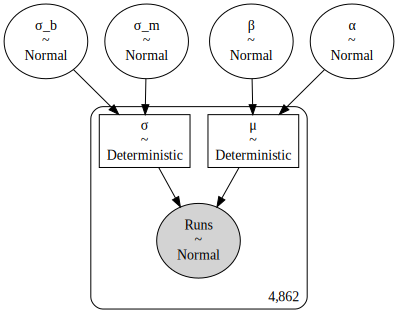

In [14]:
variance_model = pm.Model()

with variance_model:

    # Linear Regression for mean
    α = pm.Normal("α", mu=-0.5, sd=1)
    β = pm.Normal("β", mu=0.5, sd=1)
    μ = pm.Deterministic("μ", α + β * hits)
    
    # Linear Regression for deviation
    σ_m = pm.Normal("σ_m", mu=0, sd=10)
    σ_b = pm.Normal("σ_b", mu=0, sd=10)
    σ = pm.Deterministic(
        "σ", 
        1 + pm.math.exp(σ_m * hits+ σ_b)
    )

    
    # Outcome
    outcome = pm.Normal("Runs", mu=μ, sd=σ, observed=runs)
    
    # Sample from model
    trace_var = pm.sample(3000,  chains=2, cores=2, return_inferencedata=True, random_seed=4693)    
    prior_var = pm.sample_prior_predictive(200)
    trace_var.extend(az.from_pymc3(prior=prior_var))
    ppc_var = pm.sample_posterior_predictive(trace_var, samples=6000)
    trace_var.extend(az.from_pymc3(posterior_predictive=ppc_var))
        
pm.model_to_graphviz(variance_model)

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'σ_m'}>,
        <AxesSubplot:title={'center':'σ_m'}>],
       [<AxesSubplot:title={'center':'σ_b'}>,
        <AxesSubplot:title={'center':'σ_b'}>]], dtype=object)

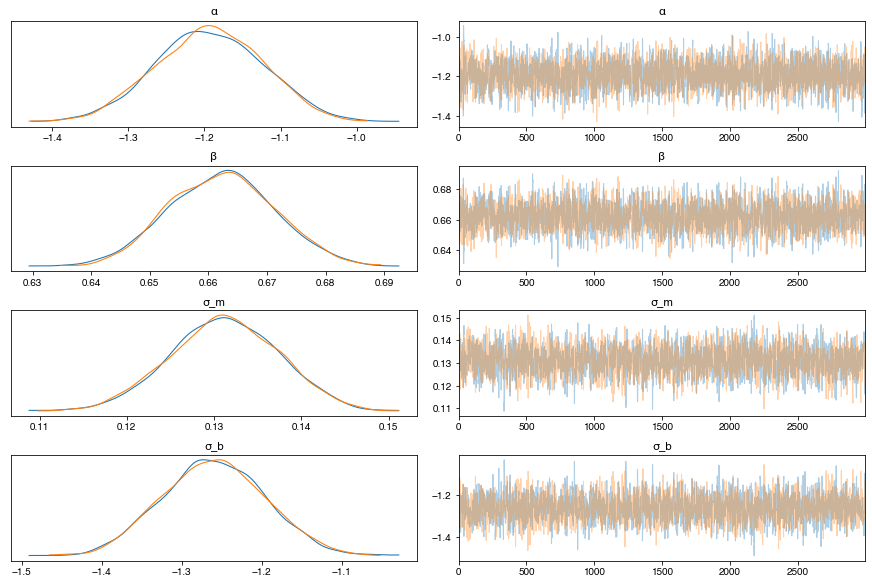

In [15]:
az.plot_trace(trace_var, var_names=["α", "β", "σ_m", "σ_b"])

/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


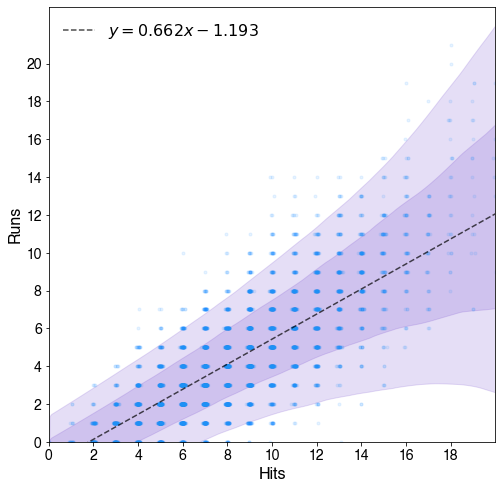

In [16]:
fig = plt.figure(figsize=(8,8))
ax =plt.gca()
az.plot_hdi(hits, ppc_var["Runs"], hdi_prob=0.68, color=SHADE_COLOR, ax=ax, 
            fill_kwargs={"alpha": SHADE_ALPHA})
az.plot_hdi(hits, ppc_var["Runs"], hdi_prob=0.95, color=SHADE_COLOR, ax=ax,
           fill_kwargs={"alpha": SHADE_ALPHA})
x = np.linspace(0,26,1000)
b = trace_var.posterior["α"].mean().item()
m = trace_var.posterior["β"].mean().item()
y = b + m * x
plt.plot(x,y, color="k", alpha=0.7, linestyle="--", 
         label=f"$y={round(m,3)}x - {abs(round(b,3))}$")
# add jitter
x = np.random.normal(hits, 0.05, size=len(hits))
plt.scatter(x, runs, marker=".", color='dodgerblue', alpha=0.1)
plt.ylim(bottom=0,top=23)
plt.xlim(left=0, right=20)
plt.legend(frameon=False, fontsize=16, loc="upper left")
plt.tick_params(labelsize=14)
plt.xlabel("Hits", fontsize=16)
plt.ylabel("Runs",fontsize=16)
plt.xticks(np.arange(0,20,2))
plt.yticks(np.arange(0,22,2))

plt.savefig("../plots/runs_v_hits/runs_v_hits_heteroscedasticity", facecolor="white", bbox_inches="tight")

This model appears to describe the data the best, encapsulates the growing variance w.r.t. number of hits.

In [17]:
comp_WAIC = pm.compare({"Standard": trace, "studentT": trace_robust, "Variance Adjusted":trace_var})
comp_WAIC

/Users/tburch/Documents/github/hierarchical-home-field/venv_pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Variance Adjusted,0,-10013.8,3.56381,0,1,58.0702,0,False,log
studentT,1,-10237.3,4.39582,223.564,2.94997e-70,56.8085,21.8445,False,log
Standard,2,-10274.1,3.96945,260.319,5.24129e-86,52.8311,25.882,False,log


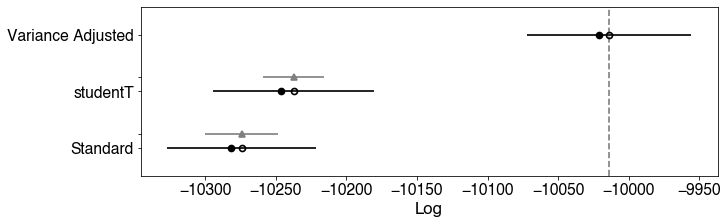

In [18]:
pm.compareplot(comp_WAIC, figsize=(10,3));

The model with non-constant variance clearly does better in terms of Leave-one-out CV, appears to be the best model choice.

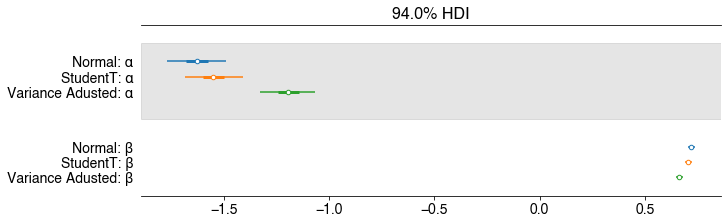

In [19]:
az.plot_forest([trace, trace_robust, trace_var],  model_names=["Normal", "StudentT","Variance Adusted"], var_names=["α","β"], combined=True, figsize=(10,3));

Here we can also see that using a model that accounts for heteroscedasticity maks the intercept change from about -1.5 to -1.0 and reduces the slope a bit too

----

The original analysis which this develops upon is below.

## Generate plot using mean eastimators

Originally decided to use a polynomial function here because it better fit the data. In retrospect, his is not well physically motivated, there's no a priori reason why this might scale as the square of runs.

In [20]:
# Helper function to get points from an axis
def get_points(ax):
    lines = ax.lines
    x = [l.get_xdata().mean() for l in lines]
    y = [l.get_ydata().mean() for l in lines]
    y_std = [l.get_ydata().std() for l in lines]
    return x[:-1], y[:-1], y_std[:-1] # For some reason this gets the entire mean as well, so drop those


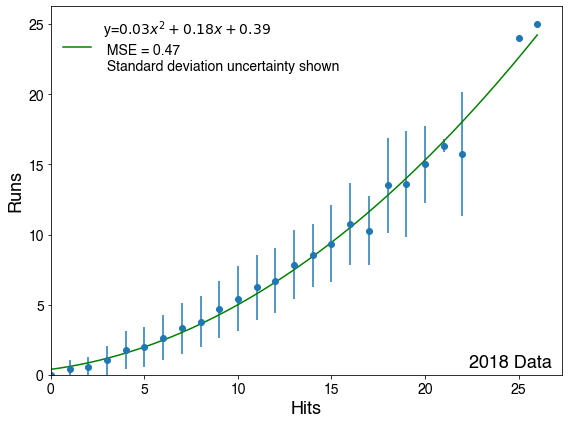

In [21]:
ax = sns.regplot(x=hits, y=runs, x_estimator=np.mean, order=2, x_ci="sd")#, label="y=$%.2fx^{2}+%.2fx+{%.2f}$"%(c2,c1,c0))
t_x, t_y, t_e  = get_points(ax)
c0, c1, c2 = np.polyfit(x=t_x,y=t_y,deg=2)
c4, c5 = np.polyfit(x=t_x,y=t_y,deg=1)

# Get MSE and r2
exponential_y = [c0*x**2 + c1*x + c2 for x in t_x]
exponential_mse = mean_squared_error(t_y, exponential_y)
#exponential_r2 = r2_score(t_y, exponential_y)

linear_y = [c4*x+c5 for x in t_x]
linear_mse = mean_squared_error(t_y, linear_y)

plt.close()
# Plot
fig = plt.figure(figsize=(8,6))
x = np.linspace(0,26,260)
y = c0*x**2 + c1*x + c2
plt.plot(x,y, 'g-', label="y=$%.2fx^{2}+%.2fx+{%.2f}$\n MSE = %.2f\n Standard deviation uncertainty shown"%(c0,c1,c2,exponential_mse))
plt.errorbar(t_x, t_y, yerr=t_e, linestyle="None", marker="o")


plt.xlabel("Hits", fontsize=18)
plt.ylabel("Runs", fontsize=18)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend(frameon=False, fontsize=14)
plt.annotate("2018 Data", xy=(0.98,0.02), xycoords="axes fraction", ha="right",fontsize=18)
plt.tight_layout()
plt.savefig('../plots/runs_v_hits')

## Check Correlation value

Additionally I made a plot looking at correlation, and plotted a simple linear regression using seaborn.

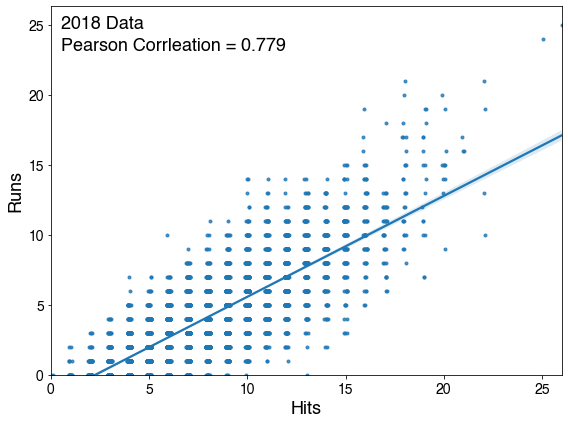

In [22]:
fig = plt.figure(figsize=(8,6))
sns.regplot(x=hits, y=runs,x_jitter=.1, marker='.')
corr = np.corrcoef(hits,runs)[0][1]

plt.xlabel("Hits", fontsize=18)
plt.ylabel("Runs", fontsize=18)
plt.gca().tick_params(axis='both', which='major', labelsize=14)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.annotate("2018 Data", xy=(0.02,0.94), xycoords="axes fraction", ha="left",fontsize=18)
plt.annotate("Pearson Corrleation = %.3f"%corr, xy=(0.02,0.88), xycoords="axes fraction", ha="left",fontsize=18)
plt.tight_layout()
plt.savefig('../plots/runs_v_hits_linregression')